<a href="https://colab.research.google.com/github/Tazkia1996/brain-mri-unet/blob/main/unet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation using UNet++


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
#pip install tensorflow==2.8.0

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import pickle

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import glob

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Load Data

In [ ]:
DataPath = '/content/gdrive/MyDrive/MSC_Thesis/lgg-mri-segmentation/kaggle_3m/'

dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [ ]:
'''image_files = []
image_masks = glob.glob('/content/gdrive/MyDrive/MSC_Thesis/lgg-mri-segmentation/kaggle_3m//*/*_mask*')

for i in image_masks:
    image_files.append(i.replace('_mask',''))

display(image_files[:1])
display(image_masks[:1])


# Fonction pour déterminer le diagnostic
def diagnostic(image_masks):
    value = np.max(cv2.imread(image_masks))
    return '1' if value > 0 else '0'   '''

"image_files = []\nimage_masks = glob.glob('/content/gdrive/MyDrive/MSC_Thesis/lgg-mri-segmentation/kaggle_3m//*/*_mask*')\n\nfor i in image_masks:\n    image_files.append(i.replace('_mask',''))\n\ndisplay(image_files[:1])\ndisplay(image_masks[:1])\n\n\n# Fonction pour déterminer le diagnostic\ndef diagnostic(image_masks):\n    value = np.max(cv2.imread(image_masks))\n    return '1' if value > 0 else '0'   "

In [ ]:
# print(masks[:10], images[:10])

In [ ]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [ ]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images': images, 'masks': masks})

In [ ]:
imagePath_df.head()

,directory,images,masks
0,TCGA_HT_8111_19980330,TCGA_HT_8111_19980330_6.tif,TCGA_HT_8111_19980330_6_mask.tif
1,TCGA_HT_8111_19980330,TCGA_HT_8111_19980330_4.tif,TCGA_HT_8111_19980330_4_mask.tif
2,TCGA_HT_8111_19980330,TCGA_HT_8111_19980330_20.tif,TCGA_HT_8111_19980330_20_mask.tif
3,TCGA_HT_8111_19980330,TCGA_HT_8111_19980330_11.tif,TCGA_HT_8111_19980330_11_mask.tif
4,TCGA_HT_8111_19980330,TCGA_HT_8111_19980330_16.tif,TCGA_HT_8111_19980330_16_mask.tif


## Image Shape

In [ ]:
def print_imShape():
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    print("Shape of Images ", image.shape)
    print("Shape of Masks ", mask.shape)

In [ ]:
for i in range(5):
    print_imShape()

Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)
Shape of Images  (256, 256, 3)
Shape of Masks  (256, 256, 3)


## Plot Images

In [ ]:
def plot_images():
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])
 #   diagnostic_value = imagePath_df['diagnostic'].iloc[idx]


    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    fig, axs = plt.subplots(1,3, figsize=[8,8])

    axs[0].imshow(image)
    axs[0].set_title('Brain MRI')

    axs[1].imshow(mask)
    axs[1].set_title('Mask')

    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    # Set the diagnostic value as the title of the mask subplot
   # axs[2].set_title(f'MRI with mask (Diagnostic: {diagnostic_value})')

    axs[2].set_title('MRI with mask')

    plt.grid(False)
    plt.show()

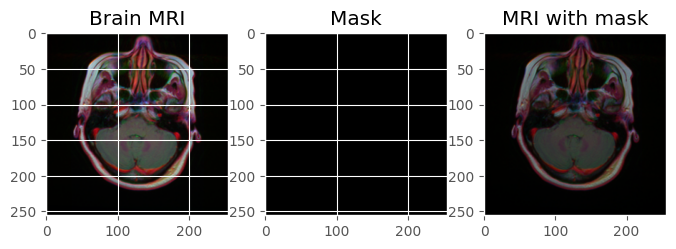

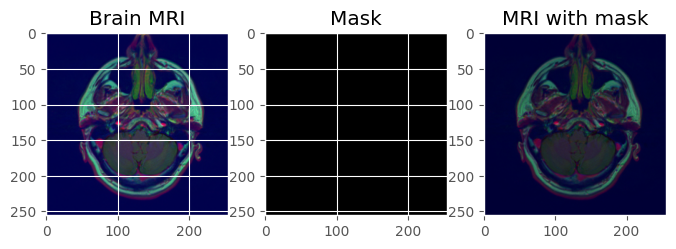

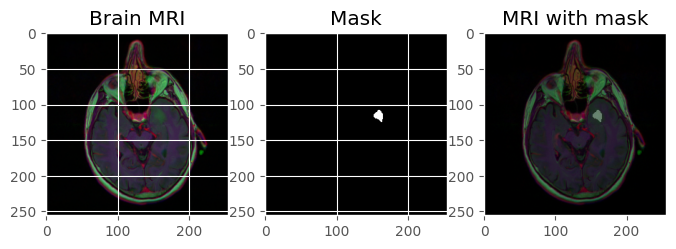

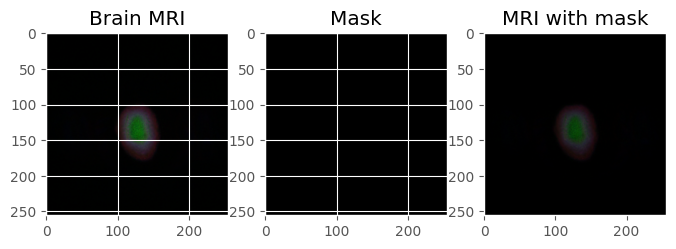

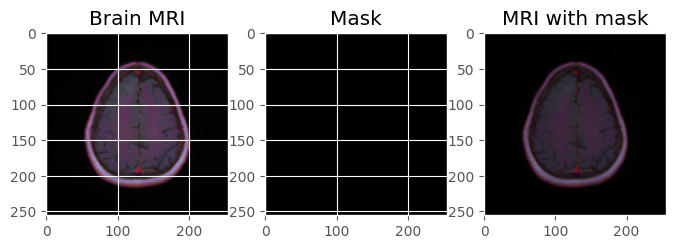

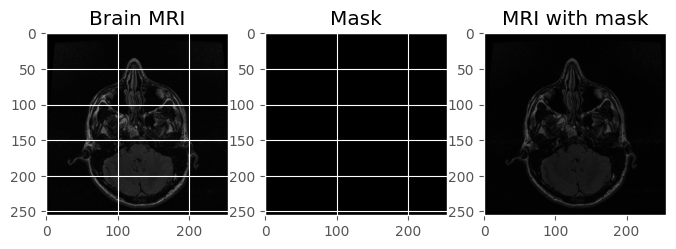

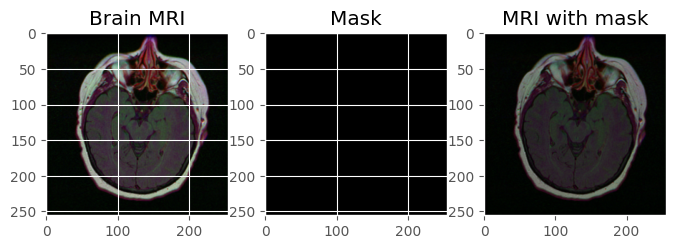

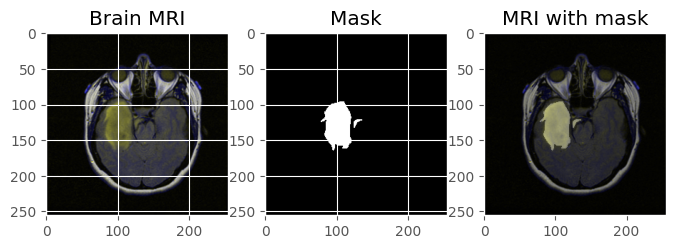

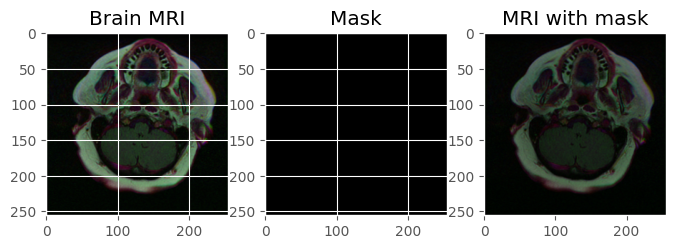

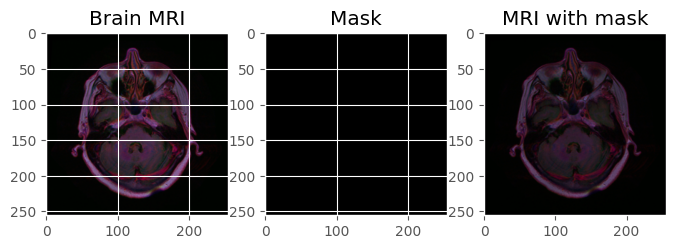

In [ ]:
for i in range(10):
    plot_images()

## Config

In [ ]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks']

In [ ]:
train , temp = train_test_split(imagePath_df, test_size=0.3, random_state=21)
test , test2 = train_test_split(temp, test_size=0.2, random_state=21)

In [ ]:
EPOCHS = 50
BATCH_SIZE = 25
ImgHieght = 256
ImgWidth = 256
Channels = 3

## Data Generator

In [ ]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

**bold text**### Train

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# mask data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 2750 validated image filenames.
Found 2750 validated image filenames.


### Validation

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
vimage_generator=imagegen.flow_from_dataframe(dataframe=test,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation mask data generator
vmask_generator=maskgen.flow_from_dataframe(dataframe=test,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 943 validated image filenames.
Found 943 validated image filenames.


##**Test**

In [ ]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)


# train generator
testimage_generator=imagegen.flow_from_dataframe(dataframe=test2,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='rgb')
# validation mask data generator
testmask_generator=maskgen.flow_from_dataframe(dataframe=test2,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHieght,ImgWidth),
                                            color_mode='grayscale')

Found 236 validated image filenames.
Found 236 validated image filenames.


In [ ]:
def data_iterator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask

In [ ]:
train_gen = data_iterator(timage_generator, tmask_generator)
valid_gen = data_iterator(vimage_generator, vmask_generator)
test_gen = data_iterator(testimage_generator, testmask_generator)

In [ ]:
# function to create dice coefficient
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten

def jaccard_loss(y_true, y_pred):
    y_true = Flatten()(y_true)
    y_pred = Flatten()(y_pred)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred) - intersection

    jaccard_loss = 1 - (intersection + 1e-15) / (union + 1e-15)

    return jaccard_loss

## UNet++

In [ ]:
nb_filter = [16,32,64,128,256]
# Build U-Net++ model
inputs = Input((ImgHieght, ImgWidth, Channels))
drop=0.1
#s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(drop) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
c2 = Dropout(drop) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)
c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
c3 = Dropout(drop) (c3)

conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
conv3_1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = BatchNormalization()(conv3_1)
conv3_1 = Dropout(drop) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)
conv2_2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = BatchNormalization()(conv2_2)
conv2_2 = Dropout(drop) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)
conv1_3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = BatchNormalization()(conv1_3)
conv1_3 = Dropout(drop) (conv1_3)

conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
conv4_1 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = BatchNormalization()(conv4_1)
conv4_1 = Dropout(drop) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)
conv3_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = BatchNormalization()(conv3_2)
conv3_2 = Dropout(drop) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)
conv2_3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = BatchNormalization()(conv2_3)
conv2_3 = Dropout(drop) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)
conv1_4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = BatchNormalization()(conv1_4)
conv1_4 = Dropout(drop) (conv1_4)

'''conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)
conv5_1 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = BatchNormalization()(conv5_1)
conv5_1 = Dropout(drop) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)
conv4_2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = BatchNormalization()(conv4_2)
conv4_2 = Dropout(drop) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)
conv3_3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = BatchNormalization()(conv3_3)
conv3_3 = Dropout(drop) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)
conv2_4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = BatchNormalization()(conv2_4)
conv2_4 = Dropout(drop) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)
conv1_5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = BatchNormalization()(conv1_5)
conv1_5 = Dropout(drop) (conv1_5)'''

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_4)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss,metrics=["accuracy", dice_coef])

In [ ]:
# get an instance of the model
# define optimizer
#adam = Adam(lr = 0.05, epsilon = 0.1)
#model.compile(optimizer=adam, loss=bce_dice_loss, metrics=[dice_loss, dsc])
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=dice_loss, metrics=["accuracy", dice_coef, dice_loss])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['batch_normalization[0][0

## Train

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5, verbose=1),
    ModelCheckpoint('/content/gdrive/MyDrive/MSC_Thesis/unetplus/modelbrainmriplus4.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
import math

STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_TRAIN = int(math.ceil(STEP_SIZE_TRAIN))
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = int(math.ceil(STEP_SIZE_VALID))
STEP_SIZE_TEST = testimage_generator.n/BATCH_SIZE
STEP_SIZE_TEST = int(math.ceil(STEP_SIZE_TEST))

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

110
38
10


In [ ]:
# Fit model
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: -0.0852 - accuracy: 0.8172 - dice_coef: 0.0852 
Epoch 1: val_loss improved from inf to -0.02049, saving model to /content/gdrive/MyDrive/MSC_Thesis/unetplus/modelbrainmriplus4.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 2107s 19s/step - loss: -0.0852 - accuracy: 0.8172 - dice_coef: 0.0852 - val_loss: -0.0205 - val_accuracy: 0.0103 - val_dice_coef: 0.0205 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: -0.1922 - accuracy: 0.9462 - dice_coef: 0.1922
Epoch 2: val_loss improved from -0.02049 to -0.24526, saving model to /content/gdrive/MyDrive/MSC_Thesis/unetplus/modelbrainmriplus4.h5
110/110 [==============================] - 78s 711ms/step - loss: -0.1922 - accuracy: 0.9462 - dice_coef: 0.1922 - val_loss: -0.2453 - val_accuracy: 0.9488 - val_dice_coef: 0.2447 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: -0.4080 - accuracy: 0.9825 - dice_coef: 0.4080
Epoch 3: val_loss did not improve from -0.24526
110/110 [==============================] - 78s 708ms/step - loss: -0.4080 - accuracy: 0.9825 - dice_coef: 0.4080 - val_loss: -0.0295 - val_accuracy: 0.0484 - val_dice_coef: 0.0294 - lr: 0.0010
Epo

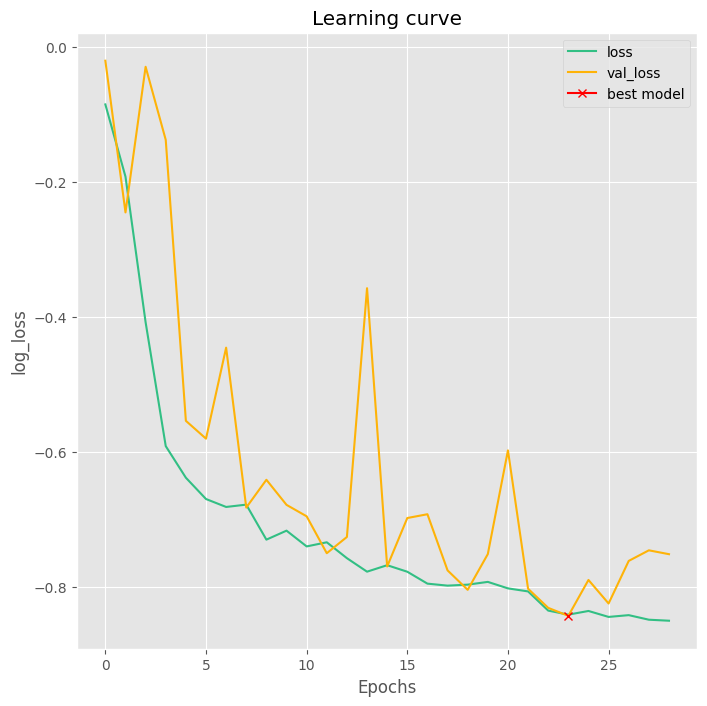

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss", color=sns.xkcd_rgb['greenish teal'])
plt.plot(results.history["val_loss"], label="val_loss", color=sns.xkcd_rgb['amber'])
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

## Prediction

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved during training
best_model = load_model('/content/gdrive/MyDrive/MSC_Thesis/unetplus/modelbrainmriplus4.h5', custom_objects={'dice_coef': dice_coef, 'dice_loss': dice_loss})

# Now, best_model contains the loaded model with the best weights.

In [ ]:
eval_results = model.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)

print("Test Loss: ", eval_results[0])
print("Test Accuracy: ", eval_results[1])
print("Test Dice: ", eval_results[2])

10/10 [==============================] - 1s 104ms/step - loss: -0.7426 - accuracy: 0.9949 - dice_coef: 0.7419
Test Loss:  -0.7425816655158997
Test Accuracy:  0.994866132736206
Test Dice:  0.7419329881668091


In [ ]:
eval_results1 = best_model.evaluate(test_gen, steps=STEP_SIZE_TEST, verbose=1)

print("Test Loss: ", eval_results1[0])
print("Test Accuracy: ", eval_results1[1])
print("Test Dice: ", eval_results1[2])

10/10 [==============================] - 2s 106ms/step - loss: -0.8566 - accuracy: 0.9976 - dice_coef: 0.8546
Test Loss:  -0.8566104173660278
Test Accuracy:  0.9976176023483276
Test Dice:  0.8545777201652527


1/1 [==============================] - 1s 955ms/step


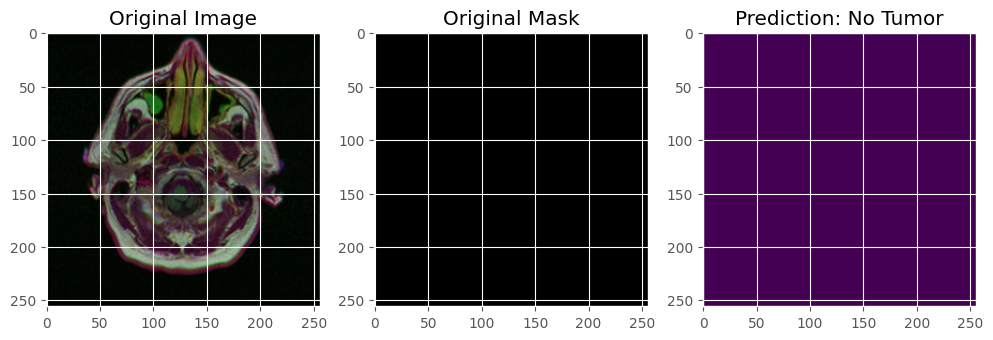

1/1 [==============================] - 0s 20ms/step


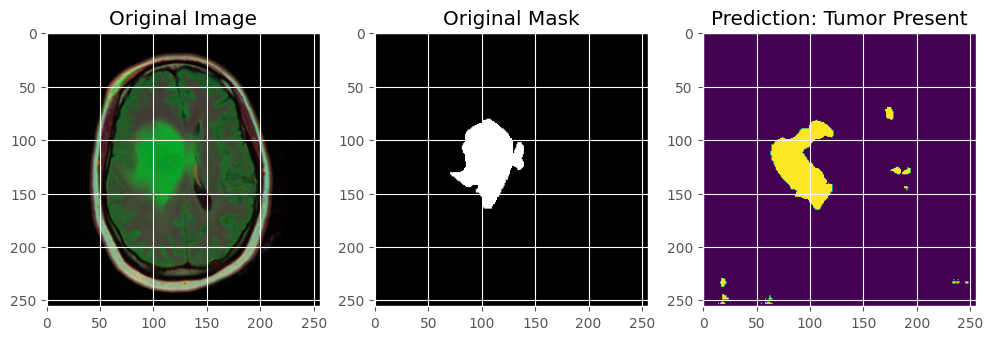

1/1 [==============================] - 0s 20ms/step


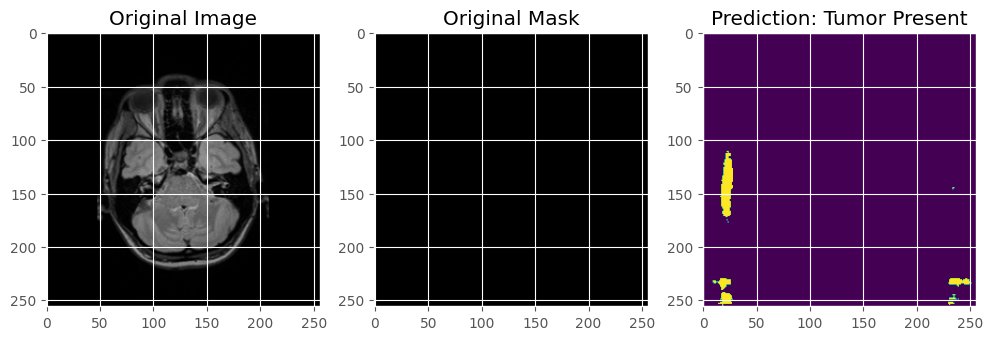

1/1 [==============================] - 0s 20ms/step


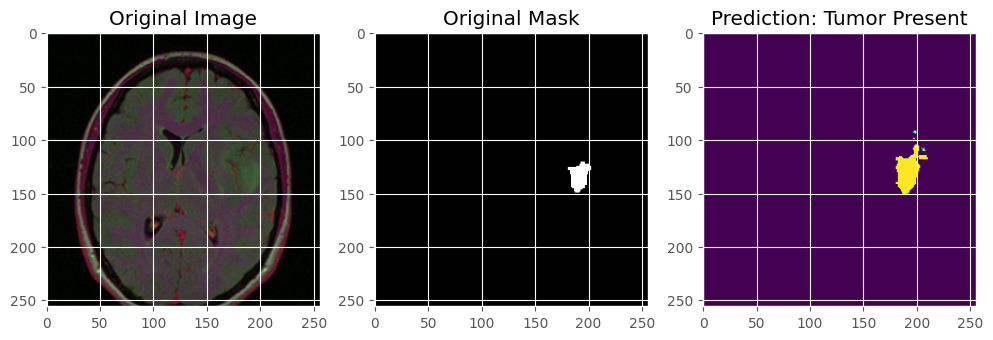

1/1 [==============================] - 0s 20ms/step


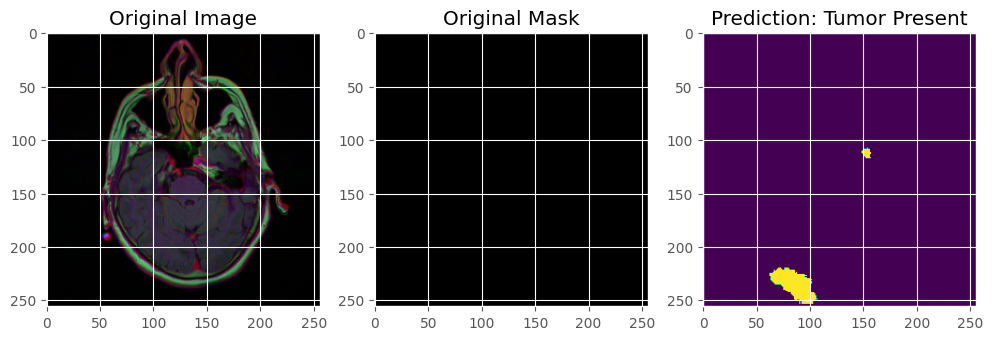

1/1 [==============================] - 0s 21ms/step


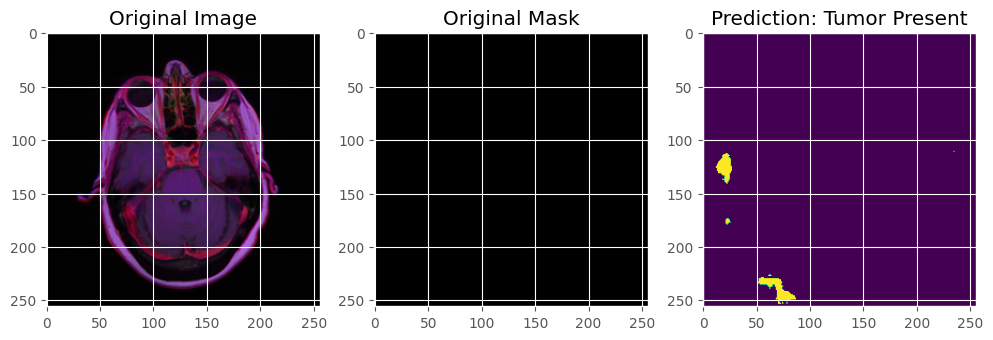

1/1 [==============================] - 0s 20ms/step


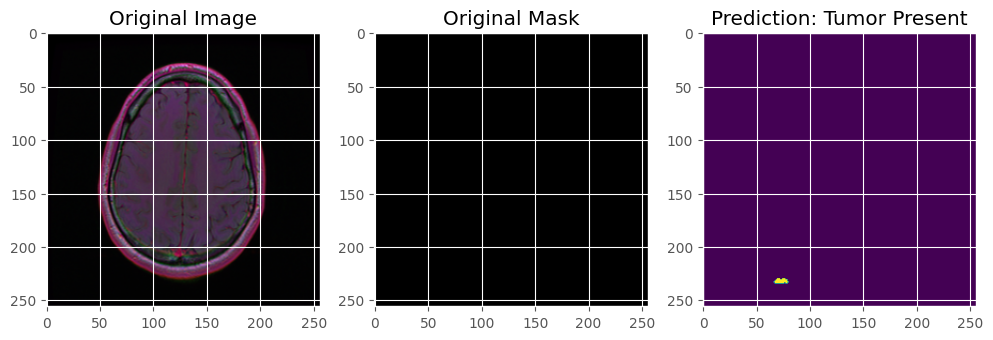

1/1 [==============================] - 0s 20ms/step


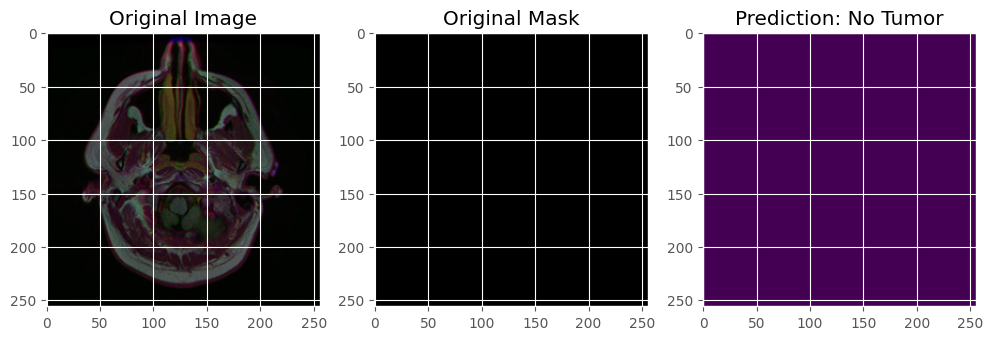

1/1 [==============================] - 0s 21ms/step


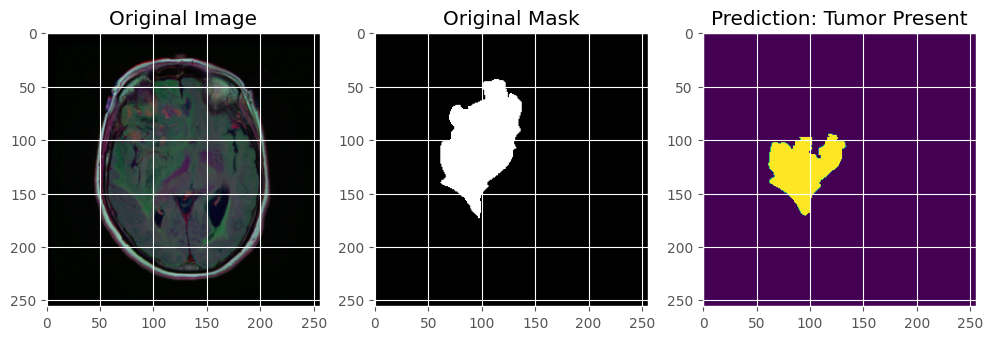

1/1 [==============================] - 0s 20ms/step


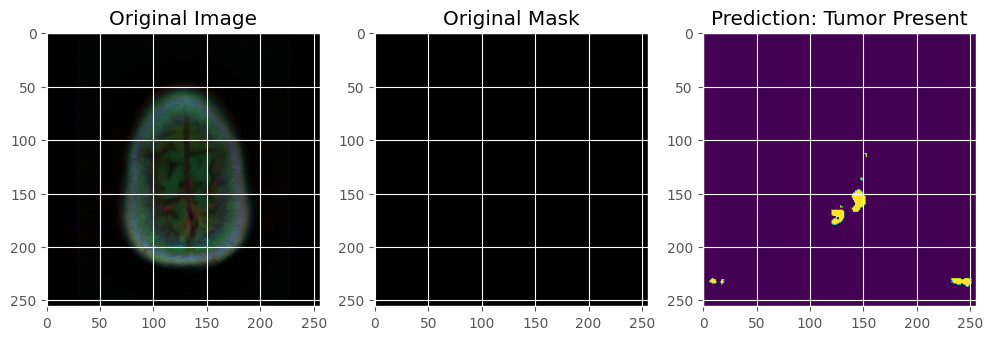

In [ ]:
for i in range(10):
    idx = np.random.randint(0, len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image ,(ImgHieght, ImgWidth))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('Original Mask')
 #   plt.subplot(1,3,3)
 #   plt.imshow(np.squeeze(pred))
  #  plt.title('Prediction')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > 0.5)
    if (np.squeeze(pred) > 0.5).any():
      label = "Prediction: Tumor Present"
    else:
      label = "Prediction: No Tumor"
    plt.title(label)
    plt.show()